In [1]:
import numpy as np
import pandas as pd
from __future__ import division
import matplotlib.pyplot as plt

## Part 1: KNN

### Warm up exercises: K-nearest-neighbors

### Exercise: K-nearest-neighbors map.

In [2]:
df = pd.read_csv("../week_3/SFPD_Incidents_-_from_1_January_2003.csv")
df = df.dropna()
columns = ["Category", "Date", "Time", "PdDistrict", 'X', 'Y']
df = df[columns]
df.head()

,Category,Date,Time,PdDistrict,X,Y
0,NON-CRIMINAL,01/19/2015,14:00,MISSION,-122.421582,37.761701
1,ROBBERY,02/01/2015,15:45,TENDERLOIN,-122.414406,37.784191
2,ASSAULT,02/01/2015,15:45,TENDERLOIN,-122.414406,37.784191
3,SECONDARY CODES,02/01/2015,15:45,TENDERLOIN,-122.414406,37.784191
4,VANDALISM,01/27/2015,19:00,NORTHERN,-122.431119,37.800469


* **Begin by using geoplotlib to plot all incidents of the three crime types (PROSTITUTION, DRUG/NARCOTIC and DRIVING UNDER THE INFLUENCE) on their own map using geoplotlib.kde(). This will give you an idea of how the varioius crimes are distributed across the city.**

In [3]:
focuscrimes = sorted(['PROSTITUTION', 'DRUG/NARCOTIC', 'DRIVING UNDER THE INFLUENCE'])

In [4]:
focuscrimes_df = df[df['Category'].isin(focuscrimes)]

In [5]:
focuscrimes_df.head()

,Category,Date,Time,PdDistrict,X,Y
11,DRUG/NARCOTIC,02/01/2015,14:00,MISSION,-122.413354,37.769075
12,DRUG/NARCOTIC,02/01/2015,14:00,MISSION,-122.413354,37.769075
31,DRUG/NARCOTIC,02/01/2015,16:56,MISSION,-122.419520,37.764229
41,DRUG/NARCOTIC,02/01/2015,17:02,MISSION,-122.419828,37.766674
61,DRIVING UNDER THE INFLUENCE,02/01/2015,18:39,NORTHERN,-122.420692,37.790577


In [6]:
import geoplotlib
from geoplotlib.utils import BoundingBox 
from scipy import stats

focuscrimes_df = focuscrimes_df[(np.abs(stats.zscore(focuscrimes_df[['X','Y']])) < 3).all(axis=1)] # remove obs that are not within 3 stds

latitute_list = focuscrimes_df['Y']
longitude_list = focuscrimes_df['X']

geo_data_for_plotting = {"lat": latitute_list,
                         "lon": longitude_list}

In [7]:
max_lat, min_lat = max(latitute_list), min(latitute_list) 
max_lon, min_lon = max(longitude_list), min(longitude_list) 

bbox = BoundingBox(north=max_lat, west=min_lon, south=min_lat, east=max_lon)
geoplotlib.set_bbox(bbox)

geoplotlib.kde(geo_data_for_plotting, bw=6, alpha=160, cut_below=1e-3)
geoplotlib.inline()

('smallest non-zero count', 1.453301797931636e-09)
('max count:', 32.775887320889446)


* **Next, it's time to set up your model based on the actual data. You can use the code supplied in the book or try out scikit-learn's KNeighborsClassifier.**


* **You can make the dataset 'balanced' by grabbing an equal number of examples from each crime category. How do you expect that will change the KNN result? In which situations is the balanced map useful - and when is the map that data in proportion to occurrences useful? Choose which map you will work on in the following.**

In [8]:
from collections import Counter

In [9]:
focuscrimes_list = Counter(focuscrimes_df['Category']).most_common()	# grab counts of all focuscrimes
least_common_crime = focuscrimes_list[-1]								# grab the least common crime as baseline 

In [10]:
least_common_crime

('DRIVING UNDER THE INFLUENCE', 5114)

In [11]:
balanced_focuscrimes_df = pd.DataFrame(columns=columns) # initialize empty balanced dataframe

# append to balanced dataframe 
for crime in focuscrimes:
    
    current_df = df[df['Category'] == crime]						 # grab current crime
    current_sample = current_df.sample(n=least_common_crime[-1])	 # randomly sample according to the least common
    
    balanced_focuscrimes_df = pd.concat([balanced_focuscrimes_df, current_sample])

In [12]:
balanced_focuscrimes_df.head()

,Category,Date,Time,PdDistrict,X,Y
504128,DRIVING UNDER THE INFLUENCE,09/16/2007,01:13,TARAVAL,-122.465829,37.740891
1410502,DRIVING UNDER THE INFLUENCE,06/10/2008,23:55,MISSION,-122.435003,37.760888
78538,DRIVING UNDER THE INFLUENCE,03/17/2014,20:53,RICHMOND,-122.479913,37.780181
445984,DRIVING UNDER THE INFLUENCE,01/03/2010,00:32,CENTRAL,-122.409880,37.795176
1041385,DRIVING UNDER THE INFLUENCE,11/15/2007,19:28,RICHMOND,-122.450092,37.782115


In [13]:
# Remove outliers as KNN is sensitive to them
balanced_focuscrimes_df = balanced_focuscrimes_df[(np.abs(stats.zscore(balanced_focuscrimes_df[['X','Y']])) < 3).all(axis=1)]

In [14]:
# Make the column categorical in pandas, so we can convert it to numerical values
balanced_focuscrimes_df['Category'] = balanced_focuscrimes_df['Category'].astype('category')
balanced_focuscrimes_df['Class'] = balanced_focuscrimes_df['Category'].cat.codes

In [15]:
balanced_focuscrimes_df.shape

(15241, 7)

In [16]:
balanced_focuscrimes_df.head()

,Category,Date,Time,PdDistrict,X,Y,Class
504128,DRIVING UNDER THE INFLUENCE,09/16/2007,01:13,TARAVAL,-122.465829,37.740891,0
1410502,DRIVING UNDER THE INFLUENCE,06/10/2008,23:55,MISSION,-122.435003,37.760888,0
78538,DRIVING UNDER THE INFLUENCE,03/17/2014,20:53,RICHMOND,-122.479913,37.780181,0
445984,DRIVING UNDER THE INFLUENCE,01/03/2010,00:32,CENTRAL,-122.409880,37.795176,0
1041385,DRIVING UNDER THE INFLUENCE,11/15/2007,19:28,RICHMOND,-122.450092,37.782115,0


* **Now create an approximately square grid of point that runs over SF. You get to decide the grid-size, but I recommend somewhere between $50 \times 50$ and $100 \times 100$ points. I recommend plotting using geoplotlib.dot().**

In [17]:
focuscrimes

['DRIVING UNDER THE INFLUENCE', 'DRUG/NARCOTIC', 'PROSTITUTION']

In [18]:
# Initialize map location #
bbox = BoundingBox(north=max_lat, west=min_lon, south=min_lat, east=max_lon)
geoplotlib.set_bbox(bbox)

colors = ["blue", "red", "green"]

for idx, crime in enumerate(focuscrimes):
    
    latitute_list = balanced_focuscrimes_df[balanced_focuscrimes_df['Category'] == crime]['Y']
    longitude_list = balanced_focuscrimes_df[balanced_focuscrimes_df['Category'] == crime]['X']
    
    geo_data_for_plotting = {"lat": latitute_list,
                             "lon": longitude_list}

    geoplotlib.dot(geo_data_for_plotting, color=colors[idx], point_size=2)


geoplotlib.inline()

In [19]:
# Model setup

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import DistanceMetric

X = balanced_focuscrimes_df[['X', 'Y']]						 # feature values
y = balanced_focuscrimes_df['Class']						 # target

knn = KNeighborsClassifier(n_neighbors=5)					 # initialize model
knn.fit(X, y)												 # fit to our data

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [20]:
# Outlier detection for regularization
 
all_distances = knn.kneighbors(X=X, n_neighbors=5, return_distance=True)	 # grab all distances
mean_dist = np.mean(all_distances[0])										 # their mean
dist_std = np.std(all_distances[0])											 # and their std
outlier_dist = mean_dist + dist_std*2										 # distance value over stds

In [21]:
np.std(all_distances[0])

0.00055013841584575717

In [22]:
outlier_dist

0.0013300615478183252

In [23]:
# Plotting

# Initialize map location
bbox = BoundingBox(north=max_lat, west=min_lon, south=min_lat, east=max_lon)
geoplotlib.set_bbox(bbox)

colors = ["blue", "red", "green"] # DUI, DRUGS, PROSTITUTION

lat_distance = max_lat - min_lat # vertical span of grid
lon_distance = max_lon - min_lon # horzontal span of grid 

lat_step = lat_distance/100 # vertical spacing between points
lon_step = lon_distance/100 # horizontal spacing between points


# Initialize dictionaries for different crimes
geo_data_for_plotting_dui = {"lat": [],
                             "lon": []}

geo_data_for_plotting_drg = {"lat": [],
                             "lon": []}

geo_data_for_plotting_prs = {"lat": [],
                             "lon": []}

# for each point in our 100x100 grid
for i in np.arange(min_lat, max_lat, lat_step): # iterate through LAT
    for j in np.arange(min_lon-0.03, max_lon+0.01, lon_step): # iterate through LON
        
        # grab the current grid point and its distances to its NN
        current_pred = np.array([[j, i]])
        current_distances = knn.kneighbors(X=current_pred, n_neighbors=5, return_distance=True)[0]        
        
        # check if it's in a sparse area or not
        if np.mean(current_distances) > outlier_dist:
            current_pred = ''
        else:
            current_pred = knn.predict(current_pred)     
        
        if current_pred == 0:							# DUI
            geo_data_for_plotting_dui['lat'].append(i)
            geo_data_for_plotting_dui['lon'].append(j)
        elif current_pred == 1:							# DRUGS
            geo_data_for_plotting_drg['lat'].append(i)
            geo_data_for_plotting_drg['lon'].append(j)
        elif current_pred == 2:							# PROSTITUTION
            geo_data_for_plotting_prs['lat'].append(i)
            geo_data_for_plotting_prs['lon'].append(j)

geoplotlib.dot(geo_data_for_plotting_dui, color="blue", point_size=1.5)
geoplotlib.dot(geo_data_for_plotting_drg, color="red", point_size=1.5)
geoplotlib.dot(geo_data_for_plotting_prs, color="green", point_size=1.5)
            
geoplotlib.inline()

KNN
Linear Regression
Mutlivariate 

## Part 2: Linear Regression (DSFS Chapter 14)

## Part 3: Building an understanding of Multiple Regression and Logistic Regression

## Part 4: Use regression models

### Exercise: Fun with linear regression.

First - we build a dataframe with the to be used in the univariate regression

In [269]:
df.loc[:, 'Year'] = df.loc[:,'Date'].apply(lambda x: x.split("/")[-1])
df.loc[:, 'Hour'] = df.loc[:,('Time')].apply(lambda x: x.split(":")[0])		 # a column with first elem of time (H)
df = df[df['Hour'].isin(hours)]											 # grab only obs betwee 05-17

In [270]:
# Training period (dataset) is 2015
df_2015 = df[df['Year'] == '2015']
df_2015.head()

,Category,Date,Time,PdDistrict,X,Y,Year,Hour
0,NON-CRIMINAL,01/19/2015,14:00,MISSION,-122.421582,37.761701,2015,14
1,ROBBERY,02/01/2015,15:45,TENDERLOIN,-122.414406,37.784191,2015,15
2,ASSAULT,02/01/2015,15:45,TENDERLOIN,-122.414406,37.784191,2015,15
3,SECONDARY CODES,02/01/2015,15:45,TENDERLOIN,-122.414406,37.784191,2015,15
5,NON-CRIMINAL,02/01/2015,16:21,RICHMOND,-122.451782,37.787085,2015,16


In [271]:
crimes_hours_2015 = Counter(df_2015['Hour'])
crimes_hours_2015

Counter({'05': 1713,
         '06': 2316,
         '07': 3752,
         '08': 5276,
         '09': 6168,
         '10': 6478,
         '11': 6933,
         '12': 9580,
         '13': 7562,
         '14': 7389,
         '15': 8241,
         '16': 8738})

* **We start by picking an area and a crime type, I'm starting with all of SF and LARCENY/THEFT just to have a lots of data, but you're free to try different crime types and areas. We will use 2015 data for training.**

In [268]:
df_regr = df.loc[df['Category'] == 'LARCENY/THEFT', :]								 # grab only theft
df_regr.loc[:, 'Year'] = df_regr.loc[:,'Date'].apply(lambda x: x.split("/")[-1])	 # add the year of crime to df_regr

In [25]:
df_regr = df_regr[df_regr['Year'] == '2015']	 # grab only obs from 2015

In [26]:
df_regr.head()

,Category,Date,Time,PdDistrict,X,Y,Year
9,LARCENY/THEFT,01/31/2015,17:00,CENTRAL,-122.417295,37.786258,2015
10,LARCENY/THEFT,02/01/2015,14:00,MISSION,-122.413354,37.769075,2015
18,LARCENY/THEFT,02/01/2015,14:30,PARK,-122.458639,37.767200,2015
34,LARCENY/THEFT,01/30/2015,22:00,PARK,-122.446484,37.750130,2015
45,LARCENY/THEFT,02/01/2015,16:44,SOUTHERN,-122.392304,37.782597,2015


In [379]:
from datetime import timedelta, date

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

In [380]:
#start_date = date(2015, 1 , 1)
#end_date = date(2016, 1, 1)

univ_regr_df = pd.DataFrame()

# Build dataframe to do the univariate linear regression

for hour in hours:																	 # loop through all our hours 
      
    current_dict = Counter(df_2015[df_2015['Hour'] == hour]['Date'])				 # grab the hours and counts
    
    for single_date in daterange(start_date, end_date):								 # fill missing values with 0
        formatted_single_date = single_date.strftime("%m/%d/%Y")
        if formatted_single_date not in current_dict:
            current_dict[formatted_single_date] = 0
            
    current_hour_df = pd.DataFrame(current_dict.items(), columns=['Date', 'Count'])	 # temp_df to concat with main
    current_hour_df['Time (x1)'] = int(hour)													 # add the current hour
    
    current_hour_df = current_hour_df.sort_values(by='Date')									 # sort according to date
    
    univ_regr_df = pd.concat([univ_regr_df, current_hour_df])								 # concat with main

univ_regr_df.head()

,Date,Count,Time (x1)
88,01/01/2015,8,5
61,01/02/2015,1,5
237,01/03/2015,3,5
95,01/04/2015,3,5
149,01/05/2015,10,5


In [279]:
univ_regr_df.shape

(4380, 3)

In [292]:
# Initializing variables
X_uni_train = univ_regr_df['Time (x1)']
y_uni_train = univ_regr_df['Count']

In [298]:
y_uni_train.shape

(4380,)

In [299]:
# Normalizing
X_uni_train_norm = (X_uni_train - X_uni_train.min()) / (X_uni_train.max() - X_uni_train.min())

In [308]:
# Fitting the data
from sklearn import linear_model

clf_univ = linear_model.LinearRegression()

clf_univ.fit(np.array(X_uni_train_norm).reshape(-1,1),  y_uni_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [329]:
# Select the first observation - which is at 05 o'clock (0 after normalization)
quick_test = X_uni_train_norm.iloc[0]
quick_test

0.0

In [330]:
# We can see that at for 05 o clock, we predict 7.5405339 crimes
clf_univ.predict(np.array([quick_test]).reshape(1,-1))

array([ 7.5405339])

In [309]:
# Define our interecept and slope variables for the univariate regression
alpha, beta_1 = clf_univ.intercept_, clf_univ.coef_

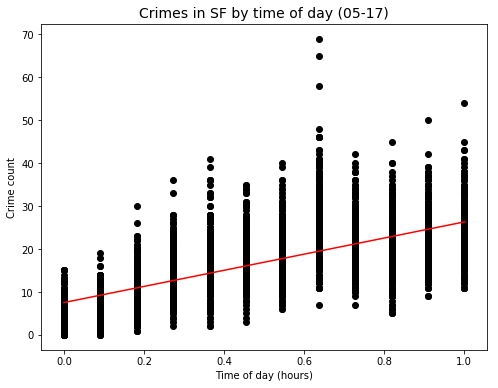

In [331]:
regression_line_limits = np.array([0,1]) # limits to extend regression lines

fig = plt.figure(figsize=(8, 6)) # initialize the general figure

ax = fig.add_subplot(1,1,1)

ax.scatter(X_uni_train_norm, y_uni_train, c='black')
ax.plot(regression_line_limits, beta_1*regression_line_limits + alpha, '-', c="r") # plot the regression line

ax.set_title("Crimes in SF by time of day (05-17)", fontsize=14)
ax.set_xlabel("Time of day (hours)")
ax.set_ylabel("Crime count")
#ax.set_xticks(X_uni_train)
#ax.set_xlim(4,17)

plt.show()

* **We need variables that have an approximately linear dependance on each other, but the daily crime counts are non-monotonic: they go up and then down again. For that reason, we will only make predictions for the interval 5am-5pm where the crime count for LARCENY/THEFT is more or less linearly increasing.**

In [372]:
import datetime
hours = [datetime.time(i).strftime('%H') for i in range(5,17)]						 # create a list of hours 

df_regr['Hour'] = df_regr.loc[:,('Time')].apply(lambda x: x.split(":")[0])		 # a column with first elem of time (H)
df_regr = df_regr[df_regr['Hour'].isin(hours)]									 # grab only obs betwee 05-17

In [28]:
df_regr.head()

,Category,Date,Time,PdDistrict,X,Y,Year,Hour
10,LARCENY/THEFT,02/01/2015,14:00,MISSION,-122.413354,37.769075,2015,14
18,LARCENY/THEFT,02/01/2015,14:30,PARK,-122.458639,37.767200,2015,14
45,LARCENY/THEFT,02/01/2015,16:44,SOUTHERN,-122.392304,37.782597,2015,16
64,LARCENY/THEFT,02/01/2015,14:30,TARAVAL,-122.473916,37.762751,2015,14
75,LARCENY/THEFT,02/01/2015,15:00,NORTHERN,-122.431310,37.785871,2015,15


**Let's check that there actually is a correlation. The goal is to first create a scatterplot.**

* Put time-of-day (in the range 05:00-17:00) on the x -axis.
* Next you go over the training data and bin and observed number of LARCENY/THEFT crimes per hour. You should have 12 data-points per day of training data.
* Plot the (time-of-day, bin-count) tuples. Does it look like there is a correlation?
* Report the Pearson-correlation.
* Now we can fit a straight line to the data, add the straight line to your scatterplot (similar to fig 14-1 in the book).

In [29]:
# count crimes according to each hour
crimes_per_hour = Counter(df_regr['Hour'])
crimes_per_hour

Counter({'05': 273,
         '06': 426,
         '07': 579,
         '08': 987,
         '09': 1366,
         '10': 1843,
         '11': 2016,
         '12': 2369,
         '13': 2086,
         '14': 2038,
         '15': 2261,
         '16': 2428})

In [30]:
# split it into a lists of times and counts
crimes_per_hour_split = zip(*sorted(crimes_per_hour.items()))
crimes_hours, crimes_counts = crimes_per_hour_split[0], crimes_per_hour_split[1]

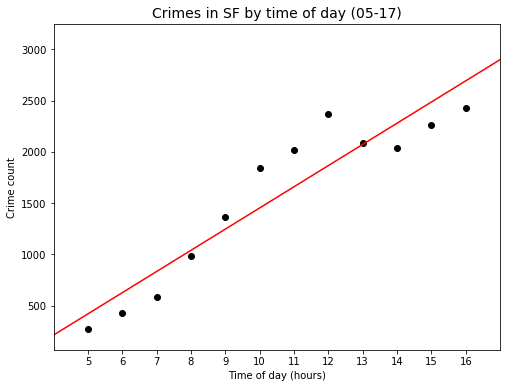

In [31]:
m, b = np.polyfit(range(5,17), crimes_counts, 1) # fit a 1 degree polynomial 
regression_line_limits = np.array([4,18]) # limits to extend regression lines

fig = plt.figure(figsize=(8, 6)) # initialize the general figure

ax = fig.add_subplot(1,1,1)

ax.scatter(crimes_hours, crimes_counts, c='black')
ax.plot(regression_line_limits, m*regression_line_limits + b, '-', c="r") # plot the regression line

ax.set_title("Crimes in SF by time of day (05-17)", fontsize=14)
ax.set_xlabel("Time of day (hours)")
ax.set_ylabel("Crime count")
ax.set_xticks(range(5,17))
ax.set_xlim(4,17)

plt.show()

In [32]:
# Pearsons correlation
np.corrcoef(range(5, 17), crimes_counts)

array([[ 1.        ,  0.93662621],
       [ 0.93662621,  1.        ]])

### Exercise: Fun with multiple regression.

* **We are going to improve our model by incorporating the total amount of crime in the area we're considering (e.g. the Tenderloin). The idea is that if there is a lot going on a certain day (e.g. a protest or a music festival taking place), then more crime in general will be happening - including more of the crime we're looking at (e.g. DRUG/NARCOTIC).**

Before we can include this in the model, however, we have to think carefully. There are two important points:

    Point 1: Difference with respect to average.

    Point 2: Rescaling. 



#### Point 1: Difference with respect to average.

In [34]:
df.loc[:, 'Year'] = df.loc[:,'Date'].apply(lambda x: x.split("/")[-1])
df.loc[:, 'Hour'] = df.loc[:,('Time')].apply(lambda x: x.split(":")[0])		 # a column with first elem of time (H)
df = df[df['Hour'].isin(hours)]											 # grab only obs betwee 05-17

In [115]:
# Training period (dataset) is 2015
df_2015 = df[df['Year'] == '2015']
df_2015.head()

,Category,Date,Time,PdDistrict,X,Y,Year,Hour
0,NON-CRIMINAL,01/19/2015,14:00,MISSION,-122.421582,37.761701,2015,14
1,ROBBERY,02/01/2015,15:45,TENDERLOIN,-122.414406,37.784191,2015,15
2,ASSAULT,02/01/2015,15:45,TENDERLOIN,-122.414406,37.784191,2015,15
3,SECONDARY CODES,02/01/2015,15:45,TENDERLOIN,-122.414406,37.784191,2015,15
5,NON-CRIMINAL,02/01/2015,16:21,RICHMOND,-122.451782,37.787085,2015,16


In [116]:
crimes_hours_2015 = Counter(df_2015['Hour'])
crimes_hours_2015

Counter({'05': 1713,
         '06': 2316,
         '07': 3752,
         '08': 5276,
         '09': 6168,
         '10': 6478,
         '11': 6933,
         '12': 9580,
         '13': 7562,
         '14': 7389,
         '15': 8241,
         '16': 8738})

In [117]:
# Calculate average number of crimes per hour for 2015
crimes_hours_2015_ave = {}

for crime in crimes_hours_2015:
    crimes_hours_2015_ave[crime] = crimes_hours_2015[crime]/365
    
crimes_hours_2015_ave

{'05': 4.693150684931507,
 '06': 6.345205479452055,
 '07': 10.27945205479452,
 '08': 14.454794520547946,
 '09': 16.898630136986302,
 '10': 17.747945205479454,
 '11': 18.994520547945207,
 '12': 26.246575342465754,
 '13': 20.71780821917808,
 '14': 20.243835616438357,
 '15': 22.578082191780823,
 '16': 23.93972602739726}

In [381]:
#start_date = date(2015, 1 , 1)
#end_date = date(2016, 1, 1)

# Build dataframe to do the linear regression

def multiv_regr_df_builder(dataframe):
    
    multiv_regr_df = pd.DataFrame()
    
    # Count the occurences of crime that year
    crimes_hours_year = Counter(dataframe['Hour'])
    
    # Calculate average number of crimes per hour for the year
    crimes_hours_year_ave = {}

    for crime in crimes_hours_year:
        crimes_hours_year_ave[crime] = crimes_hours_year[crime]/365

    
    for hour in hours:																	 # loop through all our hours 

        current_average = crimes_hours_year_ave[hour]									 # calculate the average
        current_dict = Counter(dataframe[dataframe['Hour'] == hour]['Date'])			 # grab the hours and counts

        for single_date in daterange(start_date, end_date):								 # fill missing values with 0
            formatted_single_date = single_date.strftime("%m/%d/%Y")
            if formatted_single_date not in current_dict:
                current_dict[formatted_single_date] = 0


        current_c_eff_dict = {}															 # to hold c_eff for given hour


        for date in current_dict:														 # calculate actual c_eff (365)
            current_c_eff_dict[date] = current_dict[date] - current_average

        current_hour_df = pd.DataFrame(current_c_eff_dict.items(), columns=['Date','C_eff (x2)'])	 # temp_df to concat with main
        current_hour_df['Time (x1)'] = int(hour)													 # add the current hour

        current_hour_df = current_hour_df.sort_values(by='Date')									 # sort according to date

        y_counts_df = pd.DataFrame(current_dict.items(), columns=['Date', 'Count (y)'])				 # counts (y) for each day
        current_hour_df = pd.merge(current_hour_df, y_counts_df, on='Date')							 # merge them with current

        multiv_regr_df = pd.concat([multiv_regr_df, current_hour_df])								 # concat with main
        
    return multiv_regr_df
    

multiv_regr_df_2015 = multiv_regr_df_builder(df_2015)

In [382]:
multiv_regr_df_2015.head()

,Date,C_eff (x2),Time (x1),Count (y)
0,01/01/2015,3.306849,5,8
1,01/02/2015,-3.693151,5,1
2,01/03/2015,-1.693151,5,3
3,01/04/2015,-1.693151,5,3
4,01/05/2015,5.306849,5,10


In [352]:
# This is our training set, 365*12 observations
multiv_regr_df_2015.shape

(4380, 4)

#### Point 2: Preparing the data and Rescaling

In [353]:
# Initializing X_train and y_train
X_train_multi_15 = multiv_regr_df_2015[['C_eff (x2)', 'Time (x1)']]
y_train_multi_15 = multiv_regr_df_2015['Count (y)']

In [354]:
# Normalizing / rescaling x
X_train_multi_15 = (X_train_multi_15 - X_train_multi_15.min()) / (X_train_multi_15.max() - X_train_multi_15.min())
X_train_multi_15.mean()

C_eff (x2)    0.310429
Time (x1)     0.500000
dtype: float64

In [342]:
X_train_multi_15.head()

,C_eff (x2),Time (x1)
0,0.363765,0.0
1,0.250862,0.0
2,0.283120,0.0
3,0.283120,0.0
4,0.396023,0.0


#### Fitting the data with multiple regression

In [356]:
from sklearn import linear_model

clf_multiv = linear_model.LinearRegression()

clf_multiv.fit(X_train_multi_15,  y_train_multi_15)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [357]:
clf_multiv.coef_

array([ 62.        ,  18.77555321])

In [358]:
clf_multiv.intercept_

-11.706041447137341

In [359]:
# First 5 observations - as can be seen the predictions are somewhat close to the actual counts
quick_test = X_train_multi_15.iloc[0:5,:]

clf_multiv.predict(quick_test)

array([ 10.84738321,   3.84738321,   5.84738321,   5.84738321,  12.84738321])

###  Exercise: Evaluate the two models.

First, we will select our test observations, which is the first week in January 2016 and first week in June 2016. In order to make predictions using c_eff, we must first calculate it for our 2016 test set.

In [362]:
# Select all data from 2016
df_2016 = df[df['Year'] == '2016']

In [364]:
# Calculate C_eff values for 2016
multiv_regr_df_2016 = multiv_regr_df_builder(df_2016)
multiv_regr_df_2016.head()

,Date,C_eff (x2),Time (x1),Count (y)
0,01/01/2015,-4.756164,5,0
1,01/01/2016,3.243836,5,8
2,01/02/2015,-4.756164,5,0
3,01/02/2016,-1.756164,5,3
4,01/03/2015,-4.756164,5,0


In [400]:
# Normalize
multiv_regr_df_2016['C_eff (x2)'] = (multiv_regr_df_2016['C_eff (x2)'] - multiv_regr_df_2016['C_eff (x2)'].min()) / (multiv_regr_df_2016['C_eff (x2)'].max() - multiv_regr_df_2016['C_eff (x2)'].min())
multiv_regr_df_2016['Time (x1)'] = (multiv_regr_df_2016['Time (x1)'] - multiv_regr_df_2016['Time (x1)'].min()) / (multiv_regr_df_2016['Time (x1)'].max() - multiv_regr_df_2016['Time (x1)'].min())

In [401]:
multiv_regr_df_2016.head()

,Date,C_eff (x2),Time (x1),Count (y)
0,01/01/2015,0.300569,0.0,0
1,01/01/2016,0.423646,0.0,8
2,01/02/2015,0.300569,0.0,0
3,01/02/2016,0.346723,0.0,3
4,01/03/2015,0.300569,0.0,0


In [402]:
from datetime import timedelta, date

# Create our test sets (week_A and week_B)

# first week in January (A) and first week in June (B)
week_A_list = [single_date.strftime("%m/%d/%Y") for single_date in daterange(date(2016,1,1), date(2016,1,8))] 
week_B_list = [single_date.strftime("%m/%d/%Y") for single_date in daterange(date(2016,6,1), date(2016,6,8))]

# grab their values from the 2016 df
week_A = multiv_regr_df_2016[multiv_regr_df_2016['Date'].isin(week_A_list)]
week_B = multiv_regr_df_2016[multiv_regr_df_2016['Date'].isin(week_B_list)]

In [403]:
week_A.head()

,Date,C_eff (x2),Time (x1),Count (y)
1,01/01/2016,0.423646,0.0,8
3,01/02/2016,0.346723,0.0,3
5,01/03/2016,0.362107,0.0,4
7,01/04/2016,0.331338,0.0,2
9,01/05/2016,0.315954,0.0,1


Now we can finally make predictions about our test sets

In [410]:
# Grab our inputs for week A
week_A_univ_input = np.array(week_A['Time (x1)']).reshape(-1 , 1)
week_A_multiv_input = week_A[['C_eff (x2)','Time (x1)']]

# Make our predictions for week A
week_A_predictions_univ = clf_univ.predict(week_A_univ_input)
week_A_predictions_multiv = clf_multiv.predict(week_A_multiv_input)

# Grab our inputs for week B
week_B_univ_input = np.array(week_B['Time (x1)']).reshape(-1 , 1)
week_B_multiv_input = week_B[['C_eff (x2)','Time (x1)']]

# Make our predictions for week B
week_B_predictions_univ = clf_univ.predict(week_B_univ_input)
week_B_predictions_multiv = clf_multiv.predict(week_B_multiv_input)

In [416]:
# Calculate absolute errors for both methods in week A
week_A_errors_univ = np.mean(np.sqrt((week_A['Count (y)'] - week_A_predictions_univ)**2))
week_A_errors_multiv = np.mean(np.sqrt((week_A['Count (y)'] - week_A_predictions_multiv)**2))

# Calculate absolute errors for both methods in week B
week_B_errors_univ = np.mean(np.sqrt((week_B['Count (y)'] - week_B_predictions_univ)**2))
week_B_errors_multiv = np.mean(np.sqrt((week_B['Count (y)'] - week_B_predictions_multiv)**2))

In [418]:
print("Week A univariate errors: {}".format(week_A_errors_univ))
print("Week A multivariate errors: {}".format(week_A_errors_multiv))

print("Week B univariate errors: {}".format(week_B_errors_univ))
print("Week B multivariate errors: {}".format(week_B_errors_multiv))

Week A univariate errors: 4.97993581761
Week A multivariate errors: 4.3244338006
Week B univariate errors: 4.85683294535
Week B multivariate errors: 4.32773524215


In [414]:
np.mean(np.sqrt((week_A['Count (y)'] - week_A_predictions_multiv)**2))

4.324433800598184

In [259]:
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#

In [33]:
# Grab sum of crimes for all Ts (my bins)
# Calculate no "days" in the interval (12 for time)
# Average number of crimes in a time bin = total amount of crimes/(no observations [count of all crimes])

* **Now, we start by calculating the average number of crimes in each time-bin, $c_{ave}(T)$. In practice, we do this by adding up all crimes happening in the interval throughout the training period and divide by the number of days in the training period).**

In [35]:
df.head()

,Category,Date,Time,PdDistrict,X,Y,Year,Hour
0,NON-CRIMINAL,01/19/2015,14:00,MISSION,-122.421582,37.761701,2015,14
1,ROBBERY,02/01/2015,15:45,TENDERLOIN,-122.414406,37.784191,2015,15
2,ASSAULT,02/01/2015,15:45,TENDERLOIN,-122.414406,37.784191,2015,15
3,SECONDARY CODES,02/01/2015,15:45,TENDERLOIN,-122.414406,37.784191,2015,15
5,NON-CRIMINAL,02/01/2015,16:21,RICHMOND,-122.451782,37.787085,2015,16


In [36]:
# Check how may crimes we have overall (excluding 2016 - our test set)
total_crimes_hours = Counter(df[(df['Category'] == 'LARCENY/THEFT') & (df['Year'] != '2016')]['Hour'])
total_crimes_hours

total_crimes_hours_split = zip(*sorted(total_crimes_hours.items()))
total_crimes_hours, total_crimes_counts = total_crimes_hours_split[0], total_crimes_hours_split[1]
total_crimes_counts = np.array(total_crimes_counts)

In [37]:
print(total_crimes_hours)
print(total_crimes_counts)

('05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16')
[ 2455  3937  6350 10642 12521 15313 16712 22109 19431 20272 21903 22735]


In [38]:
# calculate the number of days in our training set
no_training_days = len(np.unique(df[(df['Category'] == 'LARCENY/THEFT') & (df['Year'] != '2016')]['Date']))
no_training_days

4775

In [39]:
from sklearn.preprocessing import normalize

# Scale by the number of days we have (excluding 2016) and normalize
total_crimes_counts = total_crimes_counts/no_training_days
total_crimes_counts

array([ 0.51413613,  0.82450262,  1.32984293,  2.2286911 ,  2.62219895,
        3.20691099,  3.49989529,  4.63015707,  4.06931937,  4.24544503,
        4.58701571,  4.76125654])

In [40]:
total_crimes_counts_norm = normalize(np.array(total_crimes_counts).reshape(1,-1))
total_crimes_counts_norm

array([[ 0.04395435,  0.07048809,  0.11369046,  0.19053448,  0.22417611,
         0.27416411,  0.29921182,  0.39583976,  0.34789282,  0.36295009,
         0.39215154,  0.40704767]])

Build model with all data excluding 2016